# Time series Analysis

yang harus diperhatikan
- ACF(Autocorrelation Function) ataupub PACF(Partial ACF)
- Noise

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.stats.api
import statsmodels.tsa.api
import ipywidgets as widgets

In [8]:
DATASET_PATH = "../dataset/RNN/Netflix Stock Price/NFLX.csv"
dataset = pd.read_csv(DATASET_PATH, index_col="Date", parse_dates=["Date"])
dataset

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-12-16,119.800003,123.000000,118.089996,122.639999,122.639999,13181000
2015-12-17,123.970001,126.349998,122.419998,122.510002,122.510002,17284900
2015-12-18,120.849998,122.190002,117.919998,118.019997,118.019997,17948100
2015-12-21,119.510002,119.589996,115.660004,116.629997,116.629997,11670000
2015-12-22,117.300003,117.430000,114.860001,116.239998,116.239998,9689000
...,...,...,...,...,...,...
2019-12-10,296.119995,298.940002,292.019989,293.119995,293.119995,10476100
2019-12-11,294.489990,299.429993,294.200012,298.929993,298.929993,5589800
2019-12-12,295.670013,299.170013,295.059998,298.440002,298.440002,4766600


In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1007 entries, 2015-12-16 to 2019-12-16
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1007 non-null   float64
 1   High       1007 non-null   float64
 2   Low        1007 non-null   float64
 3   Close      1007 non-null   float64
 4   Adj Close  1007 non-null   float64
 5   Volume     1007 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 55.1 KB


In [10]:
dataset.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1007.000000,1007.000000,1007.000000,1007.000000,1007.000000,1.007000e+03
mean,226.708094,229.972979,223.105690,226.670159,226.670159,9.730586e+06
std,103.305422,104.851349,101.458611,103.203785,103.203785,6.398967e+06
min,80.570000,84.699997,79.949997,82.790001,82.790001,1.616300e+06
25%,125.779999,127.165001,124.355000,125.514999,125.514999,5.573200e+06
50%,197.850006,199.440002,195.330002,198.000000,198.000000,7.857600e+06
75%,325.529999,330.835006,318.869995,325.220001,325.220001,1.178630e+07
max,421.380005,423.209991,413.079987,418.970001,418.970001,5.841040e+07


In [11]:
dataset.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [12]:
correlation = dataset.corr()
correlation

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.999489,0.999333,0.998712,0.998712,-0.095059
High,0.999489,1.000000,0.999264,0.999438,0.999438,-0.084998
Low,0.999333,0.999264,1.000000,0.999448,0.999448,-0.107404
Close,0.998712,0.999438,0.999448,1.000000,1.000000,-0.095180
Adj Close,0.998712,0.999438,0.999448,1.000000,1.000000,-0.095180
Volume,-0.095059,-0.084998,-0.107404,-0.095180,-0.095180,1.000000


<AxesSubplot:>

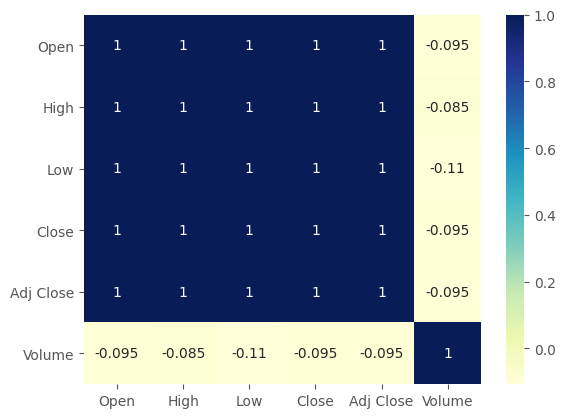

In [18]:
sns.heatmap(correlation, cmap="YlGnBu", annot=True)

In [14]:
dataset = dataset.drop(columns=['Volume'])
dataset

,Open,High,Low,Close,Adj Close
Date,,,,,
2015-12-16,119.800003,123.000000,118.089996,122.639999,122.639999
2015-12-17,123.970001,126.349998,122.419998,122.510002,122.510002
2015-12-18,120.849998,122.190002,117.919998,118.019997,118.019997
2015-12-21,119.510002,119.589996,115.660004,116.629997,116.629997
2015-12-22,117.300003,117.430000,114.860001,116.239998,116.239998
...,...,...,...,...,...
2019-12-10,296.119995,298.940002,292.019989,293.119995,293.119995
2019-12-11,294.489990,299.429993,294.200012,298.929993,298.929993
2019-12-12,295.670013,299.170013,295.059998,298.440002,298.440002


In [16]:
plt.style.use("ggplot")

## Naive Prediction

In [19]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
    np.cos(season_time * 2 * np.pi),
    1/np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period / period)
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


In [20]:
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, .05)
amplitude = 15
slope = 0.09
noise_level = 6

#Create the series
series = baseline + trend(time,slope) + seasonality(time, period=365, amplitude=amplitude)
series += noise(time, noise_level, seed=42)

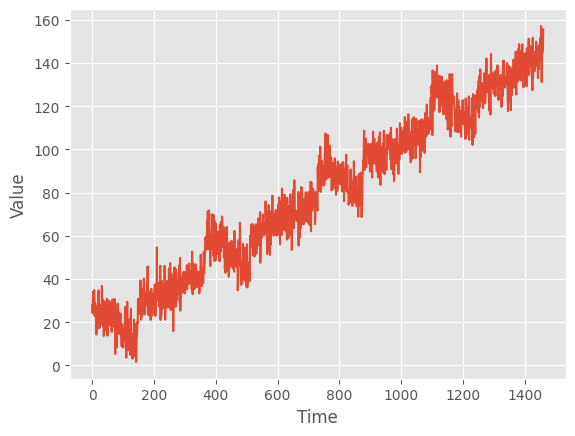

In [21]:
plot_series(time,series)

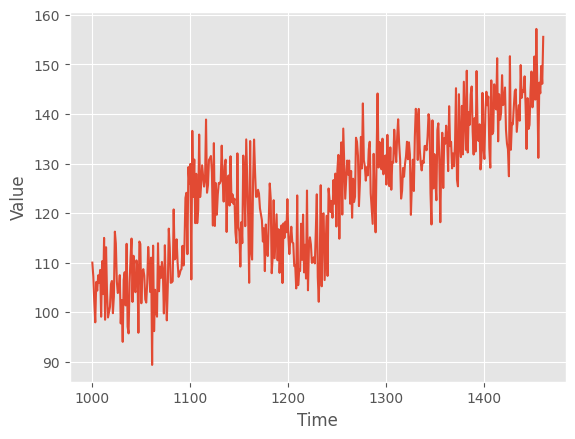

In [28]:
plot_series(time,series,start=1000)

In [29]:
import tensorflow as tf

In [41]:
time.shape

(1461,)

In [42]:
series.shape

(1461,)

In [55]:
import keras
split_time = 1000
naive_forecast = series[split_time - 1:-1]
x_valid = series[: 461]
time_valid = time[999:-1]
print(tf.keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

8045.8677
88.79841


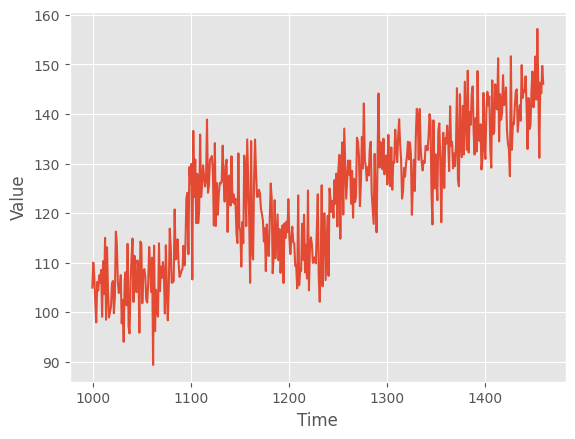

In [48]:
plot_series(x_valid, naive_forecast)

In [49]:
def moving_average_forecast(series, window_size):
    forecast =[]
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
    return np.array(forecast)

moving_avg = moving_average_forecast(series, 30)[split_time - 30:]
plt.figure(figsize=(10,6))
plot_series(time)

IndentationError: expected an indented block (3347588966.py, line 1)